<a 
href="https://colab.research.google.com/github/wingated/cs474_labs_f2019/blob/master/DL_Lab6.ipynb"
  target="_parent">
  <img
    src="https://colab.research.google.com/assets/colab-badge.svg"
    alt="Open In Colab"/>
</a>

# Lab 6: Sequence-to-sequence models

### Description:
For this lab, you will code up the [char-rnn model of Karpathy](http://karpathy.github.io/2015/05/21/rnn-effectiveness/). This is a recurrent neural network that is trained probabilistically on sequences of characters, and that can then be used to sample new sequences that are like the original.

This lab will help you develop several new skills, as well as understand some best practices needed for building large models. In addition, we'll be able to create networks that generate neat text!

### Deliverable:
- Fill in the code for the RNN (using PyTorch's built-in GRU).
- Fill in the training loop
- Fill in the evaluation loop. In this loop, rather than using a validation set, you will sample text from the RNN.
- Implement your own GRU cell.
- Train your RNN on a new domain of text (Star Wars, political speeches, etc. - have fun!)

### Grading Standards:
- 20% Implementation the RNN
- 20% Implementation training loop
- 20% Implementation of evaluation loop
- 20% Implementation of your own GRU cell
- 20% Training of your RNN on a domain of your choice

### Tips:
- Read through all the helper functions, run them, and make sure you understand what they are doing
- At each stage, ask yourself: What should the dimensions of this tensor be? Should its data type be float or int? (int is called `long` in PyTorch)
- Don't apply a softmax inside the RNN if you are using an nn.CrossEntropyLoss (this module already applies a softmax to its input).

### Example Output:
An example of my final samples are shown below (more detail in the
final section of this writeup), after 150 passes through the data.
Please generate about 15 samples for each dataset.

<code>
And ifte thin forgision forward thene over up to a fear not your
And freitions, which is great God. Behold these are the loss sub
And ache with the Lord hath bloes, which was done to the holy Gr
And appeicis arm vinimonahites strong in name, to doth piseling 
And miniquithers these words, he commanded order not; neither sa
And min for many would happine even to the earth, to said unto m
And mie first be traditions? Behold, you, because it was a sound
And from tike ended the Lamanites had administered, and I say bi
</code>


---

## Part 0: Readings, data loading, and high level training

---

There is a tutorial here that will help build out scaffolding code, and get an understanding of using sequences in pytorch.

* Read the following

> * [Pytorch sequence-to-sequence tutorial](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html) (Take note that you will not be implementing the encoder part of this tutorial.)
* [Understanding LSTM Networks](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)






In [2]:
! wget -O ./text_files.tar.gz 'https://piazza.com/redirect/s3?bucket=uploads&prefix=attach%2Fjlifkda6h0x5bk%2Fhzosotq4zil49m%2Fjn13x09arfeb%2Ftext_files.tar.gz' 
! tar -xzf text_files.tar.gz
! pip install unidecode
! pip install torch

import unidecode
import string
import random
import re
import pdb
 
all_characters = string.printable
n_characters = len(all_characters)
file = unidecode.unidecode(open('./text_files/lotr.txt').read())
file_len = len(file)
print('file_len =', file_len)

--2021-02-28 02:52:21--  https://piazza.com/redirect/s3?bucket=uploads&prefix=attach%2Fjlifkda6h0x5bk%2Fhzosotq4zil49m%2Fjn13x09arfeb%2Ftext_files.tar.gz
Resolving piazza.com (piazza.com)... 34.195.100.100, 3.226.166.24, 3.208.138.178, ...
Connecting to piazza.com (piazza.com)|34.195.100.100|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-uploads.piazza.com/attach/jlifkda6h0x5bk/hzosotq4zil49m/jn13x09arfeb/text_files.tar.gz [following]
--2021-02-28 02:52:21--  https://cdn-uploads.piazza.com/attach/jlifkda6h0x5bk/hzosotq4zil49m/jn13x09arfeb/text_files.tar.gz
Resolving cdn-uploads.piazza.com (cdn-uploads.piazza.com)... 13.35.90.127, 13.35.90.114, 13.35.90.48, ...
Connecting to cdn-uploads.piazza.com (cdn-uploads.piazza.com)|13.35.90.127|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1533290 (1.5M) [application/x-gzip]
Saving to: ‘./text_files.tar.gz’

./text_files.tar.gz 100%[===================>]   1.46M  --.-KB/s    

In [3]:
chunk_len = 200
 
def random_chunk():
  start_index = random.randint(0, file_len - chunk_len)
  end_index = start_index + chunk_len + 1
  return file[start_index:end_index]
  
print(random_chunk())

an he had been, 




though he kept close to Frodo and avoided the glance of Faramir. 

'Your guide must be blindfolded,' said Faramir, 'but you and your 
servant Samwise I release from this, if you wi


In [4]:
import torch
# Turn string into list of longs
def char_tensor(string):
  tensor = torch.zeros(len(string)).long()
  for c in range(len(string)):
      tensor[c] = all_characters.index(string[c])
  return tensor

print(char_tensor('abcDEF'))

tensor([10, 11, 12, 39, 40, 41])


---

## Part 4: Creating your own GRU cell 

**(Come back to this later - its defined here so that the GRU will be defined before it is used)**

---

The cell that you used in Part 1 was a pre-defined Pytorch layer. Now, write your own GRU class using the same parameters as the built-in Pytorch class does.

Please try not to look at the GRU cell definition. The answer is right there in the code, and in theory, you could just cut-and-paste it. This bit is on your honor!

**TODO:**

**DONE:**
* Create a custom GRU cell

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Input size must be hidden size because each layer in the GRU expects the output 
# layer to be the same size as the previous layer's output (including the input).
class GRU(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers):
    super(GRU, self).__init__()

    # print(f'[CONSTRUCTOR]\tinput_size={input_size}, hidden_size={hidden_size}, num_layers={num_layers}')
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.num_layers = num_layers

    # Formulas taken from lecture slides.
    self.Wxr = [nn.Linear(input_size, hidden_size)] * num_layers
    self.Whr = [nn.Linear(hidden_size, hidden_size)] * num_layers
    self.Rt = [nn.Sigmoid()] * num_layers

    self.Wxz = [nn.Linear(input_size, hidden_size)] * num_layers
    self.Whz = [nn.Linear(hidden_size, hidden_size)] * num_layers
    self.Zt = [nn.Sigmoid()] * num_layers

    self.Wxh = [nn.Linear(input_size, hidden_size)] * num_layers
    self.Whh = [nn.Linear(hidden_size, hidden_size)] * num_layers
    self.Htan = [nn.Tanh()] * num_layers
  
  # Run GRU computations for each hidden layer. Each layer does on runthrough
  # of the formula. Where ** is hadamard product (not matrix multiplication, 
  # but elementwise multiplication)
  def forward(self, input, hidden):
    # print(f'[FORWARD]\tinput_size={input.shape}, hidden_size={hidden.shape}')

    # The Ores is the result of running this GRU. The output Ores will equal 
    # the last row of Hres. Hres will be the hidden states from the previous 
    # run. The caller will send these in. Unos = torch.ones((1))
    Ores = torch.zeros((1, 1, self.hidden_size))
    Hres = torch.zeros(hidden.shape)
    # print(f'[FORWARD RES]\tOres={Ores.shape}, Hres={Hres.shape}')

    # The initial input is the input passed into the function. The Hidden
    # value will be the first element in the layers of hidden states.
    Xt = input.view((self.input_size))
    
    # Run through each GRU layer, creating hidden states as we go.
    for i in range(self.num_layers):
      # print(f'[ITERATION]\titeration={i + 1}')

      # The hidden layer from the previous call. The caller will pass this in.
      Ht0 = hidden[i, 0, :]

      # r_t = sigmoid(W_ir*x_t + b_ir + W_hr*h_(t-1) + b_hr)
      out_Rt = self.Rt[i](self.Wxr[i](Xt) + self.Whr[i](Ht0))

      # z_t = sigmoid(W_iz*x_t + b_iz + W_hz*h_(t-1) + b_hz)
      out_Zt = self.Zt[i](self.Wxz[i](Xt) + self.Whz[i](Ht0))

      # n_t = tanh(W_in*x_t + b_in + r_t**(W_hn*h_(t-1) + b_hn))
      out_Htan = self.Htan[i](self.Wxh[i](Xt) + out_Rt * self.Whh[i](Ht0))

      # h_(t) = (1 - z_t)**n_t + z_t**h_(t-1)
      out_Ht1 = out_Zt*Ht0 + (1-out_Zt)*out_Htan

      # As we go, construct the hidden state which will be returned to the 
      # caller. The caller will use this next time they call this method.
      # This is redundant, but whatever. Compooter does my bidding.
      Ores[0, 0, :] = out_Ht1[:]
      Hres[i, 0, :] = out_Ht1[:]

      # The input will be the previous layer's output.
      Xt = out_Ht1

    # Ht0 is the new hidden state and Xt is the new output. Each is obtained 
    # from the last runthrough of the layers.
    return Ores, Hres

---

##  Part 1: Building a sequence to sequence model

---

Great! We have the data in a useable form. We can switch out which text file we are reading from, and trying to simulate.

We now want to build out an RNN model, in this section, we will use all built in Pytorch pieces when building our RNN class.


**TODO:**

**DONE:**
* Create an RNN class that extends from nn.Module.

In [6]:
class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, n_layers=1):
    super(RNN, self).__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.output_size = output_size
    self.n_layers = n_layers
    
    # This will transform the characters into some sort of encoding.
    self.embedding = nn.Embedding(input_size, hidden_size)

    # The GRU for long short term memory.
    self.gru = GRU(hidden_size, hidden_size, n_layers)

    # The GRU output is of size hidden_size, we must transform it to output_size.
    self.linear = nn.Linear(hidden_size, output_size)

    # Probabilities cannot be less than 1.
    self.relu = nn.ReLU()

  def forward(self, input_char, hidden):
    embedded = self.embedding(input_char).view(1, 1, -1)

    # print(f'[RNN_BEFORE]\tembedded_size={embedded.shape}, hidden_size={hidden.shape}')
    output, hidden = self.gru(embedded, hidden)
    # print(f'[RNN_AFTER]\tembedded_size={embedded.shape}, hidden_size={hidden.shape}, ', end='')
    # print(f'hidden==output={torch.allclose(output[0, 0, :], hidden[-1, 0, :])}')
    
    output = self.linear(output)
    output = self.relu(output)

    return output, hidden

  def init_hidden(self):
    return torch.zeros(self.n_layers, 1, self.hidden_size)

In [7]:
def random_training_set():    
  chunk = random_chunk()
  inp = char_tensor(chunk[:-1])
  target = char_tensor(chunk[1:])
  return inp, target

---

## Part 2: Sample text and Training information

---

We now want to be able to train our network, and sample text after training.

This function outlines how training a sequence style network goes. 

**TODO:**

**DONE:**

* Fill in the pieces.

In [8]:
def train(inp, target):
  decoder_optimizer.zero_grad()
  hidden = decoder.init_hidden()
  loss = 0
  
  # Propagate each character through the RNN. Keep track of loss.
  for inp_char, target_char in zip(inp, target):
    output, hidden = decoder(inp_char, hidden)
    # print(f'[OUTPUT]\toutput_size={output.shape}, hidden_size={hidden.shape}')

    yhat = output.squeeze(0)
    ytru = target_char.unsqueeze(0)
    loss += decoder_objective(yhat, ytru)

  loss.backward()
  decoder_optimizer.step()

  score = loss.item() / inp.shape[0]
  return score

# Just for testing
# ----------------
# n_epochs = 5000
# print_every = 200
# plot_every = 10
# hidden_size = 200
# n_layers = 3
# lr = 0.001

# decoder = RNN(n_characters, hidden_size, n_characters, n_layers)
# decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
# decoder_objective = nn.CrossEntropyLoss()

# inp, target = random_training_set()
# train(inp[:1], target[:1])

---

## Part 3: Sample text and Training information

---

You can at this time, if you choose, also write out your train loop boilerplate that samples random sequences and trains your RNN. This will be helpful to have working before writing your own GRU class.

If you are finished training, or during training, and you want to sample from the network you may consider using the following function. If your RNN model is instantiated as `decoder`then this will probabilistically sample a sequence of length `predict_len`

**TODO:**

**DONE:**

* Fill out the evaluate function to generate text frome a primed string

In [9]:
def evaluate(prime_str='A', predict_len=100, temperature=0.8):
  hidden = decoder.init_hidden()
  cprime = char_tensor(prime_str)

  for cprime_char in cprime[:-2]:
    output, hidden = decoder(cprime_char, hidden)

  # Predict remaining predict_len characters
  gprediction = prime_str
  gprime_char = cprime[-1]
  for _ in range(predict_len):
    output, hidden = decoder(gprime_char, hidden)
    pred_idx = torch.multinomial(torch.exp(output.view(-1)) / temperature, 1)
    pred_char = all_characters[pred_idx]

    # Move onto next character prediction.
    gprediction += pred_char
    gprime_char = char_tensor(pred_char)

  return gprediction

---

## Part 4: (Create a GRU cell, requirements above)

---



---

## Part 5: Run it and generate some text!

---


**TODO:** 


**DONE:**
* Create some cool output



Assuming everything has gone well, you should be able to run the main function in the scaffold code, using either your custom GRU cell or the built in layer, and see output something like this. I trained on the “lotr.txt” dataset, using chunk_length=200, hidden_size=100 for 2000 epochs. These are the results, along with the prime string:

---

 G:
 
 Gandalf was decrond. 
'All have lord you. Forward the road at least walk this is stuff, and 
went to the long grey housel-winding and kindled side was a sleep pleasuring, I do long 
row hrough. In  

 lo:
 
 lost death it. 
'The last of the gatherings and take you,' said Aragorn, shining out of the Gate. 
'Yes, as you there were remembaused to seen their pass, when? What 
said here, such seven an the sear 

 lo:
 
 low, and frod to keepn 
Came of their most. But here priced doubtless to an Sam up is 
masters; he left hor as they are looked. And he could now the long to stout in the right fro horseless of 
the like 

 I:
 
 I had been the 
in his eyes with the perushed to lest, if then only the ring and the legended 
of the less of the long they which as the 
enders of Orcovered and smood, and the p 

 I:
 
 I they were not the lord of the hoomes. 
Home already well from the Elves. And he sat strength, and we 
housed out of the good of the days to the mountains from his perith. 

'Yess! Where though as if  

 Th:
 
 There yarden 
you would guard the hoor might. Far and then may was 
croties, too began to see the drumbred many line 
and was then hoard walk and they heart, and the chair of the 
Ents of way, might was 

 G:
 
 Gandalf 
been lat of less the round of the stump; both and seemed to the trees and perished they 
lay are speered the less; and the wind the steep and have to she 
precious. There was in the oonly went 

 wh:
 
 which went out of the door. 
Hull the King and of the The days of his brodo 
stumbler of the windard was a thing there, then it been shining langing 
to him poor land. They hands; though they seemed ou 

 ra:
 
 rather,' have all the least deather 
down of the truven beginning to the house of sunk. 
'Nark shorts of the Eyes of the Gate your great nothing as Eret. 
'I wander trust horn, and there were not, it  

 I:
 
 I can have no mind 
together! Where don't may had one may little blung 
terrible to tales. And turn and Gandalf shall be not to as only the Cattring 
not stopped great the out them forms. On they she lo 

---


In [10]:
import time

# Loss 1, 200 epochs, myGRU: 4.5307
# Loss 1, 200 epochs, nnGRU: 2.7616

n_epochs = 5000
print_every = 200
plot_every = 10
hidden_size = 200
n_layers = 2
lr = 0.0005
 
decoder = RNN(n_characters, hidden_size, n_characters, n_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
decoder_objective = nn.CrossEntropyLoss()
 
start = time.time()
all_losses = []
loss_avg = 0

In [290]:
# n_epochs = 2000
for epoch in range(1, n_epochs + 1):
  loss_ = train(*random_training_set())       
  loss_avg += loss_

  if epoch % print_every == 0:
      print('[%s (%d %d%%) %.4f]' % (time.time() - start, epoch, epoch / n_epochs * 100, loss_))
      print(evaluate('Wh', 100), '\n')

  if epoch % plot_every == 0:
      all_losses.append(loss_avg / plot_every)
      loss_avg = 0

[67.06448197364807 (200 4%) 3.3017]
uZ8@W?>,lgsN%.2s.'A ath ;cr i@ 

[131.6867253780365 (400 8%) 2.7362]
Wh9(a+w)_iL yit;h a^Lr a305~N0Kb|vf rMaUrond ath, ingd  
Rforues lolnhd takhiend r. okemuro 
u sJiygu 

[196.7047998905182 (600 12%) 2.6277]
WhXg. ;ain ml, o2
n0Y<K47ma%\p&Sreiother,d st, loterys B alXUQvA0)$.'no mo_xalld wand flyse=st ertse 

[261.7774467468262 (800 16%) 2.4623]
WhSoW^!>/ygy asice mad5sak mtan iing theshemey romfe 
'0 Wend foerakri tom a
s enca5ksid?ou2: 


'ymh 

[327.6191055774689 (1000 20%) 2.4880]
.W
'ton loteQ.red tats frou9ligered wheet in orskithe arsed werar5s The wit thei 
a 

[392.69993805885315 (1200 24%) 2.2981]
Wh9k tecersoke, yo te Gwseaf rrkozHTrine and 
o
l. iIns y. wan bthe atit intnge sod nbesan, irs and ha 

[457.30964279174805 (1400 28%) 2.4327]
Wh/jquynd Os Bree cma t c<%OO4 fi sede. uth A toon fore 
arnd.' th 
ourwoand tsthe ourthit eon wsaye a 

[522.2043805122375 (1600 32%) 2.2455]
Whabthe xWhaind h^o the the the sit 
uWng, 


\ngouin st

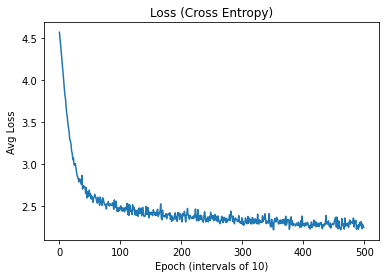

In [291]:
import matplotlib.pyplot as plt

# Show plots for this round of fitting.
plt.title('Loss (Cross Entropy)')
plt.plot(all_losses)
plt.xlabel(f'Epoch (intervals of {plot_every})')
plt.ylabel('Avg Loss')
plt.show()

In [292]:
for i in range(10):
  start_strings = [" Th", " wh", " he", " I ", " ca", " G", " lo", " ra"]
  start = random.randint(0,len(start_strings)-1)
  print(start_strings[start])
#   all_characters.index(string[c])
  print(evaluate(start_strings[start], 200), '\n')

 I 
 I bift wirt any, 
fie@asf cathe sou, t, an tand will eminguthut t essid alded rowo nis toro the 
mate wo be2Gand. The [h7,' Ther was the sees sthe, sa avime ta stoAnn.' 
'ssen bent he 
wothes an 
tif S 

 Th
 Thecrad han the shaied hasol yougredyay righeo fligr bebte trhey tos th'lt of sle marig! te foou9 tha. They. 0Ky nowou nit el slolu ve thes, m, hien fareB` butont tellim baye the oErengrut aciwan. 
om"a 

 wh
w h, fof im bes nowe gad ake to, and and hit hit seresg inonga toealnd le rofas th`+'ly out hungong #Uned fercen,' withe 0uderlame thesno biscetorind linging, fais6 
towsoto rame 
	soth reut, inet 

 lo
 lof. rurs wis Ad d an hacke le verim. 
've and at[-inod But the mef two hrea and ot goront wonnses theover canint stuhes Ume fon wared thoutt. 


U'WG Ibma lt car. Thoth antles raind ad shat we %to 
Oth 

 wh
 who V
the 
'gill as to thin thers owono bamed to the the musin the lldot out ared nd eormit?' 
si{kn ght. 
~cherom wan borboutraGawna ty ot hogs hat wan Therka 

---

## Part 6: Generate output on a different dataset

---

**TODO:**


**DONE:**

* Choose a textual dataset. Here are some [text datasets](https://www.kaggle.com/datasets?tags=14104-text+data%2C13205-text+mining) from Kaggle 

* Generate some decent looking results and evaluate your model's performance (say what it did well / not so well)
  * What went well
    * The model produced sentence-like output. By this I mean with spaces and occasional punctuation.
    * The model produced words that sounded somewhat like real english words, but they were incorrectly spelled. For example "ungry" instead of "hungry" was outputed.
    * The words produced, though not real words, can mostly be pronounced. I thought that was interesting, it seems like it's learning to pick up how words look, not necessarily what real words are.
    * The output kind of has the humor of avatar, albeit a very primitive variation of it.
  * What did not go so well
    * Some random characters such as "\", "\n", and "~" were outputted. I believe this is because the alphabet was so large. Some undesired noise was created.
    * The sentences don't make any sense. It's clear that the model is learning something, but it isn't learning something that's grammatically correct.

In [11]:
from google.colab import auth
auth.authenticate_user()

import gspread
from oauth2client.client import GoogleCredentials

gc = gspread.authorize(GoogleCredentials.get_application_default())

# Load the avatar last air bender script!
worksheet = gc.open('atla_script.csv').sheet1

# get_all_values gives a list of rows.
rows = worksheet.get_all_values()
# print(rows)

# Convert to a DataFrame and render.
import pandas as pd
avatar_frame = pd.DataFrame.from_records(rows)
avatar_text = avatar_frame[5]
avatar_frame

,0,1,2,3,4,5
0,book,episode,title,url,character,text
1,1,1,The Boy in the Iceberg,https://avatar.fandom.com/wiki/Transcript:The_...,Katara,Water. Earth. Fire. Air. My grandmother used t...
2,1,1,The Boy in the Iceberg,https://avatar.fandom.com/wiki/Transcript:The_...,,"As the title card fades, the scene opens onto ..."
3,1,1,The Boy in the Iceberg,https://avatar.fandom.com/wiki/Transcript:The_...,Sokka,It's not getting away from me this time. [Clos...
4,1,1,The Boy in the Iceberg,https://avatar.fandom.com/wiki/Transcript:The_...,,"The shot pans quickly from Sokka to Katara, wh..."
...,...,...,...,...,...,...
13444,3,21,"Sozin's Comet, Part 4: Avatar Aang",https://avatar.fandom.com/wiki/Transcript:Sozi...,Sokka,I thought it looked more exciting that way. [M...
13445,3,21,"Sozin's Comet, Part 4: Avatar Aang",https://avatar.fandom.com/wiki/Transcript:Sozi...,Iroh,"[Points at painting.] Hey, my belly's not that..."
13446,3,21,"Sozin's Comet, Part 4: Avatar Aang",https://avatar.fandom.com/wiki/Transcript:Sozi...,Toph,Well I think you all look perfect! [They laugh.]
13447,3,21,"Sozin's Comet, Part 4: Avatar Aang",https://avatar.fandom.com/wiki/Transcript:Sozi...,,"Aang walks past Appa, petting him briefly, bef..."


In [13]:
def avatar_random_chunk():
  idx = random.randint(0, len(avatar_text))
  return avatar_text[idx]

def avatar_random_training_set():    
  chunk = avatar_random_chunk()
  inp = char_tensor(chunk[:-1])
  target = char_tensor(chunk[1:])
  return inp, target

print(avatar_random_chunk())

[Hopeful.] Maybe we can find some water there!


In [15]:
import time

n_epochs = 5000
print_every = 200
plot_every = 10
hidden_size = 200
n_layers = 1
lr = 0.0008
 
decoder = RNN(n_characters, hidden_size, n_characters, n_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
decoder_objective = nn.CrossEntropyLoss()
 
start = time.time()
all_losses = []
loss_avg = 0

In [16]:
for epoch in range(1, n_epochs + 1):
  loss_ = train(*random_training_set())       
  loss_avg += loss_

  if epoch % print_every == 0:
      print('[%s (%d %d%%) %.4f]' % (time.time() - start, epoch, epoch / n_epochs * 100, loss_))
      print(evaluate('Wh', 100), '\n')

  if epoch % plot_every == 0:
      all_losses.append(loss_avg / plot_every)
      loss_avg = 0

[72.68963718414307 (200 4%) 3.0597]
k5=?H THR2J0|E<(X
0{YJz! 

[143.88332056999207 (400 8%) 2.6443]
Whi 
fthae nwcofr 
don the ming eres pAeuf a.dg osthhe 
 
ndh or-"qo2L~Ang|[ wryM end the. ouustn go o 

[215.03109860420227 (600 12%) 2.4317]
Wham of 
culflelildt bop|8]gve as thilig b7rhe. 
'
me. 
av(igw lmedit, 
acv<sl. Hpog hthin n fthber h 

[286.7176122665405 (800 16%) 2.4337]
Who mes, fougtre of mithea srp" thedo ned, ot.' aldave|A the we dese was aghes, er si]llId wree tcinyu 

[358.1236209869385 (1000 20%) 2.3090]
Whearnod thete fXf 

pe&r. 

'(.s|`lok tot hean, Zomtowaseut bed ou tnea cout hime and 
heminngzi Ugin 

[429.23982548713684 (1200 24%) 2.2389]
Whakl adtas indo mase mhe tougern toumri Rorergoingil. 


'opo0Qruoupl pads harU\o|d and owphat stthe  

[500.3304159641266 (1400 28%) 2.2454]
Whe stid wannd idlof cham th fotower itey 


eqsede.' 2
cmed y hi 
r hit fl andhe chatrhe ere slid wo  

[571.5660266876221 (1600 32%) 2.5043]
Whierte t' 

'. At tlom%id calfo not rod h

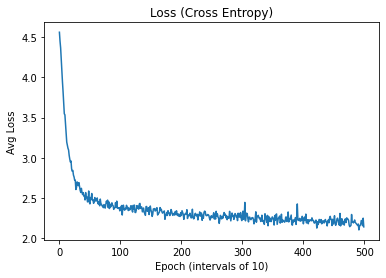

In [17]:
import matplotlib.pyplot as plt

# Show plots for this round of fitting.
plt.title('Loss (Cross Entropy)')
plt.plot(all_losses)
plt.xlabel(f'Epoch (intervals of {plot_every})')
plt.ylabel('Avg Loss')
plt.show()

In [18]:
for i in range(10):
  start_strings = ["A", " Ka", " he", " I ", " ca", " G", " La", " ra"]
  start = random.randint(0, len(start_strings) - 1)
  print(start_strings[start])
  print(evaluate(start_strings[start], 200), '\n')

 Ka
 Kan
dPaint, ta 


com. galmeend ift nombben the beal yited 
^er't hat cakretly ousdo Oter ad the sommey pan havinck and %tyof 
rathe ponig won or ton apt ine ded ands hand, and paind ous /pipsuhats lome 

 Ka
 Kasm. 


qubtin, 
cesow. 


rod[erak. 

I and the rou way 6ksn nask leirms bean thes addod wertho, to 
he0Veid 
ain ghe hiss beng, as onk sit gont cerarof to 
and /ofr they marWh, #ag an lat and ofod to 

 La
 Lave wins touh. 

And 
yo be 
Idway to lly bat hond he wis to regthermi thof thy wes ha thind na tow and. 'I ~een ffretney, his, nyow. '~binn Yepass &de 
wound thirgr ous hide dow arm dowe 4a wice that 

 La
 Laveed wile whe asslenp athesensifll. I uts 
woons meosked, zanderd iWhigr 2uned ber then bere thie ff Amer thoure whis)(n 
osut. &' 
At hos he rob romen +thered tornos, ano fllius sas oynest couns, ad 

A
Ad. 'What pell dichod, eraw sen, out bnill misewlhad velinth, bo wer{dot 




weld youkr the starm ricinn ghareed was nond (reked, why 
ous beer. ' 


ccon ho